In [70]:
!pip install shapely

In [71]:
import pandas as pd
import json
import numpy as np
import ast
from shapely.geometry import Polygon, Point
from shapely.ops import cascaded_union

In [97]:
df = pd.read_csv('data_remodeled3.csv')
df.shape

(38354, 69)

In [98]:
columns_to_remove = [
    'pass.recipient.id','pass.recipient.name','pass.body_part.id','pass.body_part.name','pass.outcome.id','pass.outcome.name','pass.aerial_won',
    'pass.cross','pass.deflected','pass.switch','pass.assisted_shot_id','pass.goal_assist','pass.shot_assist','pass.through_ball','pass.technique.id',
    'pass.cut_back','pass.no_touch','pass.miscommunication','out','off_camera','_id','match_id','pass.type.id','pass.type.name','pass.technique.name',
    'counterpress'
]

In [99]:
df.drop(columns_to_remove,axis=1,inplace=True)

In [100]:
df.isna().sum()

_id_x                                0
id                                   0
index                                0
period                               0
timestamp                            0
minute                               0
second                               0
type.id                              0
type.name                            0
possession                           0
possession_team.id                   0
possession_team.name                 0
play_pattern.id                      0
play_pattern.name                    0
team.id                              0
team.name                            0
player.id                            0
player.name                          0
position.id                          0
position.name                        0
location[0]                          0
location[1]                          0
duration                             0
under_pressure                       0
pass.length                          0
pass.angle               

In [101]:
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(38354, 43)
(31318, 43)


In [102]:
for i in df.columns:
    if('freeze' in i):
        print(i)

freeze_frame
freeze_frame_related_events[0]


In [103]:
df['team.name'].value_counts()

Bayer Leverkusen            2572
Spain                       1172
England                     1093
Spain Women's                937
Switzerland                  851
                            ... 
Darmstadt 98                  68
Costa Rica Women's            68
Freiburg                      64
Borussia Mönchengladbach      54
RB Leipzig                    44
Name: team.name, Length: 103, dtype: int64

In [104]:
def to_flat_list(row):
    """
    Calculate the area of a polygon given a flat list of coordinates.
    
    :param flat_list: List of coordinates [x1, y1, x2, y2, ...]
    :return: The area of the polygon.
    """
    flat_list = ast.literal_eval(row['visible_area'])
    if len(flat_list) % 2 != 0:
        raise ValueError("The flat list should contain an even number of elements.")
    
    # Convert the flat list to a list of (x, y) tuples
    points = [(flat_list[i], flat_list[i + 1]) for i in range(0, len(flat_list), 2)]
    
    return points

def polygon_area(row):
    points = row['visible_area_points']
    polygon = Polygon(points)
    pitch_polygon = Polygon([(0, 0), (120, 0), (120, 80), (0, 80)])
    return polygon.intersection(pitch_polygon).area

In [105]:
df['visible_area_points'] = df.apply(to_flat_list, axis=1)

In [106]:
df['visible_area_points'].head()

0    [(43.65320519956768, 80.0), (49.57877683118286...
1    [(48.176817444164826, 80.0), (52.1933756192666...
2    [(99.0442749628932, 80.0), (85.24408899496598,...
3    [(12.955506538062423, 80.0), (38.9016784695966...
4    [(0.0, 80.0), (0.0, 38.73442253628191), (21.67...
Name: visible_area_points, dtype: object

In [107]:
df['visible_area_calculated'] = df.apply(polygon_area, axis=1)
df['visible_area_calculated'].head()

0    1638.005142
1    1681.887569
2    3667.282176
3    3026.118136
4    2322.368209
Name: visible_area_calculated, dtype: float64

In [108]:
def calculate_area_in_own_and_opposite_half(row):
    points = row['visible_area_points']
    
    # Define the own half polygon
    own_half_polygon = Polygon([
        (0, 0),      # Bottom-left
        (60, 0),     # Bottom-right
        (60, 80),    # Top-right
        (0, 80)      # Top-left
    ])
    
    # Define the opposite half polygon
    opposite_half_polygon = Polygon([
        (60, 0),     # Bottom-left
        (120, 0),    # Bottom-right
        (120, 80),   # Top-right
        (60, 80)     # Top-left
    ])
    
    # Create a Polygon from the given points
    polygon = Polygon(points)
    
    # Calculate intersection with own half and opposite half
    own_half_intersection = polygon.intersection(own_half_polygon)
    opposite_half_intersection = polygon.intersection(opposite_half_polygon)
    
    # Calculate the areas
    own_half_area = own_half_intersection.area
    opposite_half_area = opposite_half_intersection.area
    
    return pd.Series({'own_half_area': own_half_area, 'opposite_half_area': opposite_half_area})

In [109]:
# Apply the function to the DataFrame
df[['own_half_area', 'opposite_half_area']] = df.apply(calculate_area_in_own_and_opposite_half, axis=1)

In [110]:
df[['visible_area','own_half_area', 'opposite_half_area','visible_area_calculated']].head()

,visible_area,own_half_area,opposite_half_area,visible_area_calculated
0,"[43.65320519956768, 80.0, 49.578776831182864, ...",674.523274,963.481868,1638.005142
1,"[48.176817444164826, 80.0, 52.193375619266625,...",505.677250,1176.210319,1681.887569
2,"[99.0442749628932, 80.0, 85.24408899496598, 80...",0.000000,3667.282176,3667.282176
3,"[12.955506538062423, 80.0, 38.901678469596696,...",2391.971002,634.147134,3026.118136
4,"[0.0, 80.0, 0.0, 38.73442253628191, 21.6711782...",2322.368209,0.000000,2322.368209


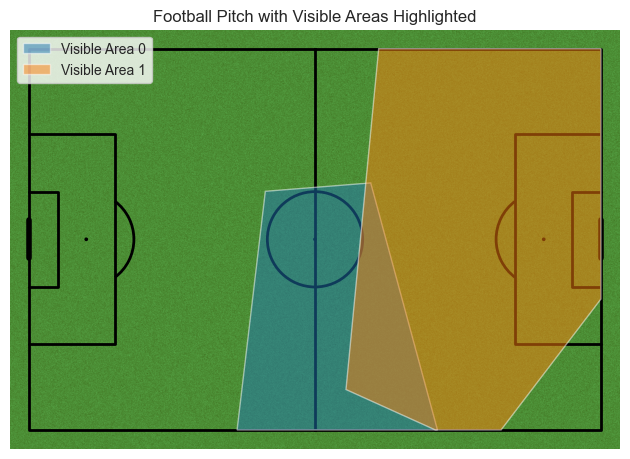

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from shapely.geometry import Polygon

# Example DataFrame
df_sample = pd.DataFrame({
    'visible_area_points': [
        [43.65320519956768, 80.0, 49.578776831182864, 29.924816646722174, 71.69162253937003, 28.166989859431776, 85.69439870238537, 80.0, 43.65320519956768, 80.0],  # Example polygon coordinates
        [99.0442749628932, 80.0, 85.24408899496598, 80.0, 66.50175534059088, 71.52274626155766, 73.36005889454039, 0.0, 120.0, 0.0, 120.0, 52.525571459551415, 99.0442749628932, 80.0]  # Another example polygon
    ]
})

def plot_pitch_map(df):
    # Create a pitch instance
    pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='black')

    fig, ax = pitch.draw()

    # Plot visible areas
    for index, row in df.iterrows():
        flat_list = row['visible_area_points']
        points = [(flat_list[i], flat_list[i + 1]) for i in range(0, len(flat_list), 2)]
        
        # Convert list of points into a Shapely Polygon
        polygon = Polygon(points)
        
        # Extract x and y coordinates from the polygon
        x, y = zip(*points)
        x = list(x) + [x[0]]  # Close the polygon
        y = list(y) + [y[0]]  # Close the polygon
        
        # Plot the polygon on the pitch
        ax.fill(x, y, alpha=0.5, label=f'Visible Area {index}')
    
    # Add title and legend
    plt.title('Football Pitch with Visible Areas Highlighted')
    plt.legend()
    plt.show()

# Plot the pitch map with highlighted visible areas
plot_pitch_map(df_sample)


In [112]:
def calculate_area_in_thirds(row):
    points = row['visible_area_points']
    
    # Define the left third polygon
    left_third_polygon = Polygon([
        (0, 0),      # Bottom-left
        (40, 0),     # Bottom-right
        (40, 80),    # Top-right
        (0, 80)      # Top-left
    ])
    
    # Define the middle third polygon
    middle_third_polygon = Polygon([
        (40, 0),     # Bottom-left
        (80, 0),     # Bottom-right
        (80, 80),    # Top-right
        (40, 80)     # Top-left
    ])
    
    # Define the right third polygon
    right_third_polygon = Polygon([
        (80, 0),     # Bottom-left
        (120, 0),    # Bottom-right
        (120, 80),   # Top-right
        (80, 80)     # Top-left
    ])
    
    # Create a Polygon from the given points
    polygon = Polygon(points)
    
    # Calculate intersection with each third
    left_third_intersection = polygon.intersection(left_third_polygon)
    middle_third_intersection = polygon.intersection(middle_third_polygon)
    right_third_intersection = polygon.intersection(right_third_polygon)
    
    # Calculate the areas
    left_third_area = left_third_intersection.area
    middle_third_area = middle_third_intersection.area
    right_third_area = right_third_intersection.area
    
    return pd.Series({
        'left_third_area': left_third_area,
        'middle_third_area': middle_third_area,
        'right_third_area': right_third_area
    })

In [113]:
# Apply the function to the DataFrame
df[['left_third_area', 'middle_third_area', 'right_third_area']] = df.apply(calculate_area_in_thirds, axis=1)

In [114]:
df[['visible_area','own_half_area', 'opposite_half_area','visible_area_calculated','left_third_area', 'middle_third_area', 'right_third_area']].head()

,visible_area,own_half_area,opposite_half_area,visible_area_calculated,left_third_area,middle_third_area,right_third_area
0,"[43.65320519956768, 80.0, 49.578776831182864, ...",674.523274,963.481868,1638.005142,0.000000,1577.990388,60.014754
1,"[48.176817444164826, 80.0, 52.193375619266625,...",505.677250,1176.210319,1681.887569,0.000000,1503.756634,178.130934
2,"[99.0442749628932, 80.0, 85.24408899496598, 80...",0.000000,3667.282176,3667.282176,0.000000,761.374763,2905.907413
3,"[12.955506538062423, 80.0, 38.901678469596696,...",2391.971002,634.147134,3026.118136,996.847561,2029.270575,0.000000
4,"[0.0, 80.0, 0.0, 38.73442253628191, 21.6711782...",2322.368209,0.000000,2322.368209,2282.093645,40.274564,0.000000


In [115]:
def extract_coordinates(row):
    # Initialize lists to hold coordinates based on player role
    actor_coords = []
    teammate_coords = []
    opposition_coords = []
    goalkeeper_coords = []
    
    data = ast.literal_eval(row['freeze_frame_related_events[0]'])

    # Iterate through each item in the data
    for entry in data:
        location = entry.get('location', ())
        if entry.get('actor', False):
            actor_coords.append(location)
        elif entry.get('teammate', False):
            teammate_coords.append(location)
        elif entry.get('keeper', False):
            goalkeeper_coords.append(location)
        else:
            opposition_coords.append(location)
    
    return pd.Series({
        'actor_coordinates': [tuple(lst) for lst in actor_coords],
        'teammate_coordinates': [tuple(lst) for lst in teammate_coords],
        'goalkeeper_coordinates': [tuple(lst) for lst in goalkeeper_coords],
        'opposition_coordinates': [tuple(lst) for lst in opposition_coords]
    })

In [116]:
df[['actor_coordinates', 'teammate_coordinates', 'goalkeeper_coordinates','opposition_coordinates']] = df.apply(extract_coordinates, axis=1)

In [117]:
pd.set_option('display.max_colwidth', None) # Show full content of each column
print(df[['freeze_frame_related_events[0]','actor_coordinates', 'teammate_coordinates', 'goalkeeper_coordinates','opposition_coordinates']].head(1))

In [118]:
from shapely.validation import explain_validity
from shapely.geometry import Polygon
from shapely.ops import unary_union
from scipy.spatial import ConvexHull
import numpy as np

def calculate_area(polygon):
    if polygon.is_empty:
        return 0
    elif not polygon.is_valid:
        return 0
    else:
        return polygon.area

def create_polygon_from_points(points):
    # Convert list of lists to numpy array for ConvexHull
    points_np = np.array(points)
    
    if len(points_np) < 3:
        return Polygon()

    # Compute the convex hull of the points
    hull = ConvexHull(points_np)
    
    # Extract the vertices of the convex hull
    hull_points = points_np[hull.vertices]
    
    # Create a Polygon from the convex hull points
    polygon = Polygon(hull_points)
    
    return polygon


    

def polygon_area(data):
    try:
        points = data
        polygon = Polygon(points)
        # Check validity
        validity = explain_validity(polygon)
        if validity != 'Valid':
            # Try to fix the polygon
            fixed_polygon = polygon.buffer(0)
        pitch_polygon = Polygon([(0, 0), (120, 0), (120, 80), (0, 80)])
        return polygon.intersection(pitch_polygon).area
    except Exception as e:
        print(e)

def calculate_area_in_thirds(row):
    
    # Define the left third polygon
    left_third_polygon = Polygon([
        (0, 0),      # Bottom-left
        (40, 0),     # Bottom-right
        (40, 80),    # Top-right
        (0, 80)      # Top-left
    ])
    
    # Define the middle third polygon
    middle_third_polygon = Polygon([
        (40, 0),     # Bottom-left
        (80, 0),     # Bottom-right
        (80, 80),    # Top-right
        (40, 80)     # Top-left
    ])
    
    # Define the right third polygon
    right_third_polygon = Polygon([
        (80, 0),     # Bottom-left
        (120, 0),    # Bottom-right
        (120, 80),   # Top-right
        (80, 80)     # Top-left
    ])
    
    # Create a Polygon from the given points
    polygon = row
    
    # Calculate intersection with each third
    left_third_intersection = polygon.intersection(left_third_polygon)
    middle_third_intersection = polygon.intersection(middle_third_polygon)
    right_third_intersection = polygon.intersection(right_third_polygon)
    
    # Calculate the areas
    left_third_area = left_third_intersection.area
    middle_third_area = middle_third_intersection.area
    right_third_area = right_third_intersection.area
    
    return pd.Series({
        'left_third_area': left_third_area,
        'middle_third_area': middle_third_area,
        'right_third_area': right_third_area
    })

def calculate_area_in_own_and_opposite_half(row):
    
    # Define the own half polygon
    own_half_polygon = Polygon([
        (0, 0),      # Bottom-left
        (60, 0),     # Bottom-right
        (60, 80),    # Top-right
        (0, 80)      # Top-left
    ])
    
    # Define the opposite half polygon
    opposite_half_polygon = Polygon([
        (60, 0),     # Bottom-left
        (120, 0),    # Bottom-right
        (120, 80),   # Top-right
        (60, 80)     # Top-left
    ])
    
    # Create a Polygon from the given points
    polygon = row
    
    # Calculate intersection with own half and opposite half
    own_half_intersection = polygon.intersection(own_half_polygon)
    opposite_half_intersection = polygon.intersection(opposite_half_polygon)
    
    # Calculate the areas
    own_half_area = own_half_intersection.area
    opposite_half_area = opposite_half_intersection.area
    
    return pd.Series({'own_half_area': own_half_area, 'opposite_half_area': opposite_half_area})

In [119]:
df['teammates_polygon'] = df['teammate_coordinates'].apply(create_polygon_from_points)
df['opposition_polygon'] = df['opposition_coordinates'].apply(create_polygon_from_points)

In [120]:
df['teammates_area'] = df['teammates_polygon'].apply(calculate_area)
df['opposition_area'] = df['opposition_polygon'].apply(calculate_area)

In [121]:
df[['teammates_own_half_area','teammates_opposite_half_area']] = df['teammates_polygon'].apply(calculate_area_in_own_and_opposite_half)
df[['opposition_own_half_area','opposition_opposite_half_area']] = df['opposition_polygon'].apply(calculate_area_in_own_and_opposite_half)

In [122]:
df[['teammates_left_third_area','teammates_middle_third_area','teammates_right_third_area']] = df['teammates_polygon'].apply(calculate_area_in_thirds)
df[['opposition_left_third_area','opposition_middle_third_area','opposition_right_third_area']] = df['opposition_polygon'].apply(calculate_area_in_thirds)

In [123]:
df[['teammates_left_third_area','teammates_middle_third_area','teammates_right_third_area','teammates_own_half_area','teammates_opposite_half_area','teammates_area','opposition_area']].head()

,teammates_left_third_area,teammates_middle_third_area,teammates_right_third_area,teammates_own_half_area,teammates_opposite_half_area,teammates_area,opposition_area
0,0.000000,443.903335,0.000000,246.506749,197.396585,443.903335,320.201676
1,0.000000,443.219036,0.000000,342.511569,100.707467,443.219036,285.366620
2,927.208745,213.289059,0.000000,1140.497804,0.000000,1140.497804,1092.737312
3,0.000000,314.377570,8.048773,0.000000,322.426344,322.426344,314.277487
4,0.000000,0.000000,152.079501,0.000000,152.079501,152.079501,928.360998


In [124]:
def find_intersection(row):
    polygon1=row['teammates_polygon']
    polygon2=row['opposition_polygon']
    # Calculate the intersection of two polygons
    intersection_polygon = polygon1.intersection(polygon2)
    
    # Return the result
    return intersection_polygon

In [125]:
df.columns

Index(['_id_x', 'id', 'index', 'period', 'timestamp', 'minute', 'second',
       'type.id', 'type.name', 'possession', 'possession_team.id',
       'possession_team.name', 'play_pattern.id', 'play_pattern.name',
       'team.id', 'team.name', 'player.id', 'player.name', 'position.id',
       'position.name', 'location[0]', 'location[1]', 'duration',
       'under_pressure', 'pass.length', 'pass.angle', 'pass.height.id',
       'pass.height.name', 'pass.end_location[0]', 'pass.end_location[1]',
       'match_id_x', '_id_y', 'event_uuid', 'visible_area', 'freeze_frame',
       'match_id_y', 'class_1', 'class_2', 'class_3',
       'event_uuid_related_events[0]', 'visible_area_related_events[0]',
       'freeze_frame_related_events[0]', 'non_empty_count',
       'visible_area_points', 'visible_area_calculated', 'own_half_area',
       'opposite_half_area', 'left_third_area', 'middle_third_area',
       'right_third_area', 'actor_coordinates', 'teammate_coordinates',
       'goalkeeper_coor

In [126]:
df['conincidence_polygon'] = df.apply(find_intersection,axis=1)

In [127]:
df.shape

(31318, 69)

In [128]:
df.to_csv('random_save.csv',index=False)

In [129]:
df['conincidence_area'] = df['conincidence_polygon'].apply(calculate_area)
df[['conincidence_own_half_area','conincidence_opposite_half_area']] = df['conincidence_polygon'].apply(calculate_area_in_own_and_opposite_half)
df[['conincidence_left_third_area','conincidence_middle_third_area','conincidence_right_third_area']] = df['conincidence_polygon'].apply(calculate_area_in_thirds)

In [130]:
df['teammates_count'] = df['teammate_coordinates'].apply(len)
df['opposition_count'] = df['opposition_coordinates'].apply(len)

In [131]:
df['teammates_count'].describe()

count    31318.000000
mean         6.784277
std          2.088875
min          0.000000
25%          5.000000
50%          7.000000
75%          9.000000
max         10.000000
Name: teammates_count, dtype: float64

In [132]:
df.to_csv('random_save.csv',index=False)

In [133]:
df = pd.read_csv('random_save.csv')

In [134]:
from scipy.spatial.distance import euclidean
def calculate_distance_stats(row):
    # Extract coordinates from the row
    actor_coord = ast.literal_eval(row['actor_coordinates'])[0]  # Extract the single coordinate from the list
    teammate_coords = ast.literal_eval(row['teammate_coordinates'])
    
    # Check if teammate coordinates are not empty
    if not teammate_coords:
        return pd.Series({'min_distance': None, 'max_distance': None, 'avg_distance': None})
    # Calculate distances between actor and each teammate
    distances = [euclidean(actor_coord, teammate_coord) for teammate_coord in teammate_coords]
    
    # Calculate minimum, maximum, and average distances
    min_distance = min(distances)
    max_distance = max(distances)
    avg_distance = sum(distances) / len(distances)
    
    return pd.Series({'min_distance': min_distance, 'max_distance': max_distance, 'avg_distance': avg_distance})

def calculate_distance_stats_o(row):
    # Extract coordinates from the row
    actor_coord = ast.literal_eval(row['actor_coordinates'])[0]  # Extract the single coordinate from the list
    teammate_coords = ast.literal_eval(row['opposition_coordinates'])
    
    # Check if teammate coordinates are not empty
    if not teammate_coords:
        return pd.Series({'min_distance': None, 'max_distance': None, 'avg_distance': None})
    # Calculate distances between actor and each teammate
    distances = [euclidean(actor_coord, teammate_coord) for teammate_coord in teammate_coords]
    
    # Calculate minimum, maximum, and average distances
    min_distance = min(distances)
    max_distance = max(distances)
    avg_distance = sum(distances) / len(distances)
    
    return pd.Series({'min_distance': min_distance, 'max_distance': max_distance, 'avg_distance': avg_distance})

In [135]:
# Apply the function to each row
df[['teammate_min_distance', 'teammate_max_distance', 'teammate_avg_distance']] = df.apply(calculate_distance_stats, axis=1)

In [136]:
df[['teammate_min_distance', 'teammate_max_distance', 'teammate_avg_distance']].head()

,teammate_min_distance,teammate_max_distance,teammate_avg_distance
0,6.550906,25.480910,15.160624
1,5.375085,29.045143,12.532590
2,8.783134,44.145346,24.518677
3,4.529004,29.771923,11.761028
4,14.194615,39.440478,30.130222


In [137]:
# Apply the function to each row
df[['opposition_min_distance', 'opposition_max_distance', 'opposition_avg_distance']] = df.apply(calculate_distance_stats_o, axis=1)

In [138]:
df[['opposition_min_distance', 'opposition_max_distance', 'opposition_avg_distance']].describe()

,opposition_min_distance,opposition_max_distance,opposition_avg_distance
count,31318.000000,31318.000000,31318.000000
mean,3.361017,37.062876,18.859464
std,2.283665,11.500752,5.270158
min,0.059439,2.154522,2.154522
25%,2.011448,28.523910,15.110239
50%,2.920743,36.136189,18.433143
75%,4.064106,44.592982,22.140103
max,29.472390,77.782669,42.004072


In [139]:
def count_coordinates_comparison(row):
    # Extract coordinates from the row
    actor_coord = ast.literal_eval(row['actor_coordinates'])[0]  # Extract the single actor coordinate from the list
    teammate_coords = ast.literal_eval(row['teammate_coordinates'])
    
    # Extract the x-coordinate of the actor
    actor_x = actor_coord[0]
    
    # Extract x-coordinates of teammates
    teammate_x_coords = [coord[0] for coord in teammate_coords]
    
    # Count how many teammate x-coordinates are less than and greater than actor x-coordinate
    count_less_than_actor = sum(x < actor_x for x in teammate_x_coords)
    count_greater_than_actor = sum(x > actor_x for x in teammate_x_coords)
    
    return pd.Series({'count_less_than_actor': count_less_than_actor, 'count_greater_than_actor': count_greater_than_actor})

def count_coordinates_comparison_o(row):
    # Extract coordinates from the row
    actor_coord = ast.literal_eval(row['actor_coordinates'])[0]  # Extract the single actor coordinate from the list
    teammate_coords = ast.literal_eval(row['opposition_coordinates'])
    
    # Extract the x-coordinate of the actor
    actor_x = actor_coord[0]
    
    # Extract x-coordinates of teammates
    teammate_x_coords = [coord[0] for coord in teammate_coords]
    
    # Count how many teammate x-coordinates are less than and greater than actor x-coordinate
    count_less_than_actor = sum(x < actor_x for x in teammate_x_coords)
    count_greater_than_actor = sum(x > actor_x for x in teammate_x_coords)
    
    return pd.Series({'count_less_than_actor': count_less_than_actor, 'count_greater_than_actor': count_greater_than_actor})

In [140]:
# Apply the function to each row
df[['teammates_behind',  'teammates_in_front']] = df.apply(count_coordinates_comparison, axis=1)
df[['opposition_behind',  'opposition_in_front']] = df.apply(count_coordinates_comparison_o, axis=1)

In [141]:
df[['teammates_behind',  'teammates_in_front']].head()

,teammates_behind,teammates_in_front
0,2,7
1,6,3
2,7,3
3,4,3
4,2,1


In [142]:
import math
def point_line_segment_distance(A, B, P):
    """
    Calculate the shortest distance from point P to the line segment AB.
    
    Parameters:
    A (tuple): Coordinates of the first endpoint of the line segment (x1, y1).
    B (tuple): Coordinates of the second endpoint of the line segment (x2, y2).
    P (tuple): Coordinates of the point (x0, y0) to which the distance is to be calculated.
    
    Returns:
    float: The shortest distance from point P to the line segment AB.
    """
    x1, y1 = A
    x2, y2 = B
    x0, y0 = P

    # Compute the length of the line segment AB
    line_len_squared = (x2 - x1) ** 2 + (y2 - y1) ** 2
    
    if line_len_squared == 0:
        # A and B are the same point
        return math.sqrt((x0 - x1) ** 2 + (y0 - y1) ** 2)
    
    # Compute the projection of point P onto the line AB
    t = max(0, min(1, ((x0 - x1) * (x2 - x1) + (y0 - y1) * (y2 - y1)) / line_len_squared))
    
    # Find the projection point
    proj_x = x1 + t * (x2 - x1)
    proj_y = y1 + t * (y2 - y1)
    
    # Compute the distance from point P to the projection point
    dist_x = x0 - proj_x
    dist_y = y0 - proj_y
    
    return math.sqrt(dist_x ** 2 + dist_y ** 2)

In [143]:
def count_coordinates_comparison_m(row):
    # Extract coordinates from the row
    actor_coord = ast.literal_eval(row['actor_coordinates'])[0]  # Extract the single actor coordinate from the list
    teammate_coords = ast.literal_eval(row['teammate_coordinates'])
    opp_coords = ast.literal_eval(row['opposition_coordinates'])
    
    count=0
    
    for teammate_coord in teammate_coords:
        for opp_coord in opp_coords:
            dist = point_line_segment_distance(actor_coord,teammate_coord,opp_coord)
            if dist <= 2.040386:
                count += 1
                break
    
    return pd.Series({'passing_channels': len(teammate_coords)- count, 'passing_channels_blocked': count})

def count_coordinates_comparison_d(row):
    # Extract coordinates from the row
    actor_coord = ast.literal_eval(row['actor_coordinates'])[0]  # Extract the single actor coordinate from the list
    teammate_coords = ast.literal_eval(row['teammate_coordinates'])
    opp_coords = ast.literal_eval(row['opposition_coordinates'])
    
    count=0
    
    for teammate_coord in teammate_coords:
        for opp_coord in opp_coords:
            dist = point_line_segment_distance(actor_coord,teammate_coord,opp_coord)
            if dist <= row['opposition_min_distance']:
                count += 1
                break
    
    return pd.Series({'passing_channels': len(teammate_coords)- count, 'passing_channels_blocked': count})

In [144]:
# Apply the function to each row
df[['passing_channels_m',  'passing_channels_blocked_m']] = df.apply(count_coordinates_comparison_m, axis=1)
# Apply the function to each row
df[['passing_channels_d',  'passing_channels_blocked_d']] = df.apply(count_coordinates_comparison_d, axis=1)

In [145]:
df[['passing_channels_m',  'passing_channels_blocked_m','passing_channels_d',  'passing_channels_blocked_d']].describe()

,passing_channels_m,passing_channels_blocked_m,passing_channels_d,passing_channels_blocked_d
count,31318.000000,31318.000000,31318.000000,31318.000000
mean,2.801264,3.983013,0.000798,6.783479
std,2.295415,2.600172,0.046247,2.089320
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000
50%,3.000000,4.000000,0.000000,7.000000
75%,5.000000,6.000000,0.000000,9.000000
max,10.000000,10.000000,4.000000,10.000000


In [146]:
df.to_csv('random_save.csv',index=False)

In [147]:
df = pd.read_csv('random_save.csv')

In [148]:
X = df[['passing_channels_m',  'passing_channels_blocked_m','passing_channels_d',  'passing_channels_blocked_d','teammates_behind',  'teammates_in_front','opposition_behind',  'opposition_in_front','opposition_min_distance', 'opposition_max_distance', 'opposition_avg_distance','teammate_min_distance', 'teammate_max_distance', 'teammate_avg_distance','teammates_count','opposition_count','conincidence_left_third_area','conincidence_middle_third_area','conincidence_right_third_area','conincidence_own_half_area','conincidence_opposite_half_area','conincidence_area','teammates_left_third_area','teammates_middle_third_area','teammates_right_third_area','teammates_own_half_area','teammates_opposite_half_area','teammates_area','opposition_area','opposition_left_third_area','opposition_middle_third_area','opposition_right_third_area','opposition_own_half_area','opposition_opposite_half_area','own_half_area', 'opposite_half_area','visible_area_calculated','left_third_area', 'middle_third_area', 'right_third_area']]
y = df['class_2']

In [149]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Sample DataFrame
# Note: Replace this with your actual DataFrame
# df = pd.read_csv('your_data.csv')  # Example for loading data from a CSV file

df = df[['passing_channels_m', 'passing_channels_blocked_m', 'passing_channels_d', 'passing_channels_blocked_d',
        'teammates_behind', 'teammates_in_front', 'opposition_behind', 'opposition_in_front',
        'opposition_min_distance', 'opposition_max_distance', 'opposition_avg_distance',
        'teammate_min_distance', 'teammate_max_distance', 'teammate_avg_distance',
        'teammates_count', 'opposition_count',
        'conincidence_left_third_area', 'conincidence_middle_third_area', 'conincidence_right_third_area',
        'conincidence_own_half_area', 'conincidence_opposite_half_area', 'conincidence_area',
        'teammates_left_third_area', 'teammates_middle_third_area', 'teammates_right_third_area',
        'teammates_own_half_area', 'teammates_opposite_half_area', 'teammates_area',
        'opposition_area', 'opposition_left_third_area', 'opposition_middle_third_area',
        'opposition_right_third_area', 'opposition_own_half_area', 'opposition_opposite_half_area',
        'own_half_area', 'opposite_half_area', 'visible_area_calculated',
        'left_third_area', 'middle_third_area', 'right_third_area','class_2','class_1','class_3']]
print(df.shape)

# Define features and target
X = df[['passing_channels_m', 'passing_channels_blocked_m', 'passing_channels_d', 'passing_channels_blocked_d',
        'teammates_behind', 'teammates_in_front', 'opposition_behind', 'opposition_in_front',
        'opposition_min_distance', 'opposition_max_distance', 'opposition_avg_distance',
        'teammate_min_distance', 'teammate_max_distance', 'teammate_avg_distance',
        'teammates_count', 'opposition_count',
        'conincidence_left_third_area', 'conincidence_middle_third_area', 'conincidence_right_third_area',
        'conincidence_own_half_area', 'conincidence_opposite_half_area', 'conincidence_area',
        'teammates_left_third_area', 'teammates_middle_third_area', 'teammates_right_third_area',
        'teammates_own_half_area', 'teammates_opposite_half_area', 'teammates_area',
        'opposition_area', 'opposition_left_third_area', 'opposition_middle_third_area',
        'opposition_right_third_area', 'opposition_own_half_area', 'opposition_opposite_half_area',
        'own_half_area', 'opposite_half_area', 'visible_area_calculated',
        'left_third_area', 'middle_third_area', 'right_third_area']]
y = df['class_1']

# Handle missing values: Fill missing values with 0 (or other strategies like mean/median)
X.fillna(0, inplace=True)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Add a constant (intercept) to the model
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)


(31318, 43)


C:\Users\kakka\AppData\Local\Temp\ipykernel_33596\3151935645.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [150]:
df['class_1'].unique()

array([ 1, -1], dtype=int64)

In [151]:
# Check for missing values in features and target
print("Missing values in X:")
print(X_train.isna().sum())
print("\nMissing values in y:")
print(y_train.isna().sum())

Missing values in X:
const                              0
passing_channels_m                 0
passing_channels_blocked_m         0
passing_channels_d                 0
passing_channels_blocked_d         0
teammates_behind                   0
teammates_in_front                 0
opposition_behind                  0
opposition_in_front                0
opposition_min_distance            0
opposition_max_distance            0
opposition_avg_distance            0
teammate_min_distance              0
teammate_max_distance              0
teammate_avg_distance              0
teammates_count                    0
opposition_count                   0
conincidence_left_third_area       0
conincidence_middle_third_area     0
conincidence_right_third_area      0
conincidence_own_half_area         0
conincidence_opposite_half_area    0
conincidence_area                  0
teammates_left_third_area          0
teammates_middle_third_area        0
teammates_right_third_area         0
teammates_own_hal

In [152]:
# Check for infinite values
print("\nInfinite values in X:")
print(np.isinf(X_train).sum())


Infinite values in X:
const                              0
passing_channels_m                 0
passing_channels_blocked_m         0
passing_channels_d                 0
passing_channels_blocked_d         0
teammates_behind                   0
teammates_in_front                 0
opposition_behind                  0
opposition_in_front                0
opposition_min_distance            0
opposition_max_distance            0
opposition_avg_distance            0
teammate_min_distance              0
teammate_max_distance              0
teammate_avg_distance              0
teammates_count                    0
opposition_count                   0
conincidence_left_third_area       0
conincidence_middle_third_area     0
conincidence_right_third_area      0
conincidence_own_half_area         0
conincidence_opposite_half_area    0
conincidence_area                  0
teammates_left_third_area          0
teammates_middle_third_area        0
teammates_right_third_area         0
teammates_own_h

         Current function value: 0.525517
         Iterations: 35
Logistic Regression Model Summary:
                           Logit Regression Results                           
Dep. Variable:                class_1   No. Observations:                21922
Model:                          Logit   Df Residuals:                    21881
Method:                           MLE   Df Model:                           40
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                 0.04009
Time:                        19:21:34   Log-Likelihood:                -11520.
converged:                      False   LL-Null:                       -12001.
Covariance Type:            nonrobust   LLR p-value:                9.012e-176
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               1.1950      0.128      9.305   

C:\Users\kakka\PycharmProjects\ProjectF\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


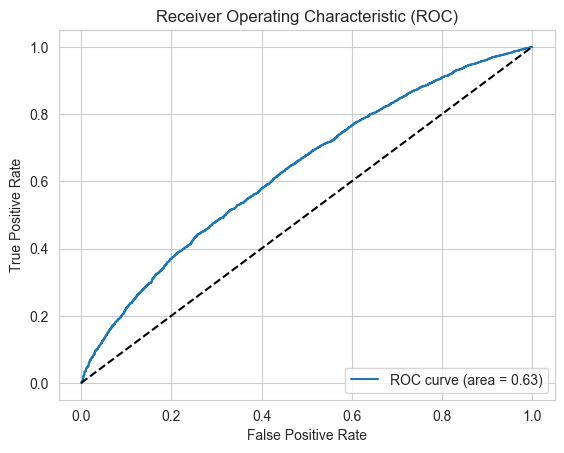


Confusion Matrix:
[[  14 2212]
 [  17 7153]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.01      0.01      2226
           1       0.76      1.00      0.87      7170

    accuracy                           0.76      9396
   macro avg       0.61      0.50      0.44      9396
weighted avg       0.69      0.76      0.66      9396


In [153]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Transform the dependent variable to binary (0 and 1)
y_train_binary = (y_train == 1).astype(int)
y_test_binary = (y_test == 1).astype(int)

# Fit the Logistic Regression model using statsmodels
model = sm.Logit(y_train_binary, X_train).fit()

# Print the summary
print("Logistic Regression Model Summary:")
print(model.summary())

# Make predictions on the test set
y_pred_probs = model.predict(X_test)

# Convert y_test to a DataFrame for consistency with y_pred_probs
y_test_binary_df = pd.DataFrame(y_test_binary)

# Create a DataFrame for predictions with correct columns
y_pred_binary = pd.DataFrame(y_pred_probs, columns=['prob'])

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Convert predicted probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype(int)

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred))


In [154]:
df = pd.read_csv('random_save.csv')
df.head()

,_id_x,id,index,period,timestamp,minute,second,type.id,type.name,possession,...,opposition_max_distance,opposition_avg_distance,teammates_behind,teammates_in_front,opposition_behind,opposition_in_front,passing_channels_m,passing_channels_blocked_m,passing_channels_d,passing_channels_blocked_d
0,66ba38692d4a508f96672224,7fd797d5-530c-4e27-bac7-8fa097c95abc,28,1,00:00:16.035,0,16,30,Pass,2,...,26.286485,15.579516,2,7,0,7,3,6,0,9
1,66ba38692d4a508f96672228,76ebbb25-3467-413b-8497-f3e38f998e57,32,1,00:00:17.549,0,17,30,Pass,2,...,17.464867,9.578916,6,3,3,4,5,4,0,9
2,66ba38692d4a508f9667224e,7a9e0311-6936-4f6d-aa56-90c0e6ff7b58,70,1,00:00:58.628,0,58,30,Pass,3,...,55.162133,22.693670,7,3,4,4,3,7,0,10
3,66ba38692d4a508f96672258,c970a836-e82c-4702-963a-b53ee7e29864,80,1,00:01:05.668,1,5,30,Pass,4,...,31.869719,13.803941,4,3,2,4,2,5,0,7
4,66ba38692d4a508f96672275,9567c2e9-b970-4b92-b4ae-7843a912906d,109,1,00:01:52.335,1,52,30,Pass,6,...,41.827142,26.457251,2,1,3,2,3,0,0,3


In [155]:
for i in df.columns:
    if('freeze' in i):
        print(i)

freeze_frame
freeze_frame_related_events[0]


In [156]:
df['pass.height.name'].value_counts()

Ground Pass    23461
High Pass       4202
Low Pass        3655
Name: pass.height.name, dtype: int64

In [157]:
df['pass.height.name'].value_counts()

Ground Pass    23461
High Pass       4202
Low Pass        3655
Name: pass.height.name, dtype: int64

In [158]:
def triangles_from_points(row):
    actor_coord = ast.literal_eval(row['actor_coordinates'])[0]  # Extract the single actor coordinate from the list
    teammate_coords = ast.literal_eval(row['teammate_coordinates'])
    triangle_list = []
    
    for i in range(len(teammate_coords)):
        for j in range(len(teammate_coords)):
            if teammate_coords[i] != teammate_coords[j]:
                triangle = [actor_coord,teammate_coords[i],teammate_coords[j]]
                triangle_list.append(triangle)
            else:
                continue
        
    return triangle_list

In [159]:
df['teammates_traingle'] = df.apply(triangles_from_points,axis=1)

In [160]:
df['teammates_traingle_count']=df['teammates_traingle'].apply(len)

In [161]:
df[['teammates_traingle','teammates_traingle_count','teammates_count']].head()

teammates_traingle  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          [[(51.0, 15.800000190734863), (46.963998884170216, 40.959242431768956), (47.531455617551615, 29.45255098085892)], [(51.0, 15.800000190734863), (46.963998884170216, 40.959242431768956), (56.41988514263958, 19.47956776111006)], [(51.0, 15.800000190734863), (46.963998884170216, 40.959242431768956), (57.27261591289059, 10.466155333834699)], [(51.0, 15.800000190734863), (46.963998884170216, 40.959242431768956), (58.0968674853102, 6.056071466329335)], [(51.0, 15.800000190734863), (46.963998884170216, 40.959242431768956), (61.722561532667605, 12.010328803779252)], [(51.0, 15.800000190734863), (46.963998884170216, 40.959242431768956), (63.21531089206784, 27.84832303376839)], [(51.0, 15.

In [162]:
def traingle_area(row):
    try:
        triangles = row['teammates_traingle']
        area = []
        for triangle in triangles:
            area.append(polygon_area(triangle))
            
        return pd.Series({
            'area_mean':np.mean(area),
            'area_min':np.min(area),
            'area_max':np.max(area)
        })
    except:
        return pd.Series({
            'area_mean':np.nan,
            'area_min':np.nan,
            'area_max':np.nan
        })
    
    

In [163]:
df[['teammates_traingle_area_mean','teammates_traingle_area_min','teammates_traingle_area_max']] = df.apply(traingle_area,axis=1)

C:\Users\kakka\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kakka\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\kakka\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kakka\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\kakka\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kakka\AppData\Loca

In [164]:
df[['teammates_traingle_area_mean','teammates_traingle_area_min','teammates_traingle_area_max']].describe()

,teammates_traingle_area_mean,teammates_traingle_area_min,teammates_traingle_area_max
count,30958.000000,30958.000000,30958.000000
mean,113.861644,17.113094,302.542332
std,55.270076,30.230387,154.690099
min,0.042132,0.000000,0.042132
25%,73.617422,2.634699,191.662960
50%,104.434366,7.116918,277.449689
75%,143.628449,17.229711,385.561661
max,607.466338,607.466338,1590.197193


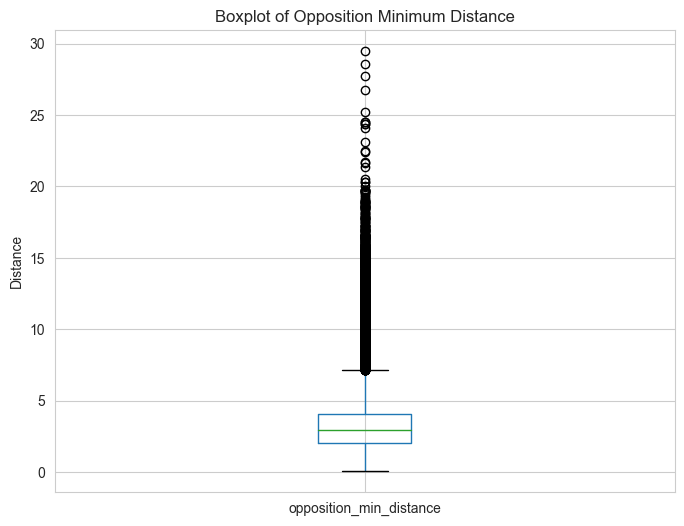

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size if needed
df.boxplot(column='opposition_min_distance')
plt.title('Boxplot of Opposition Minimum Distance')
plt.ylabel('Distance')
plt.show()

In [166]:
def extract_coordinates_pressure(row):
    # Initialize lists to hold coordinates based on player role
    actor_coords = []
    teammate_coords = []
    opposition_coords = []
    goalkeeper_coords = []
    
    data = ast.literal_eval(row['freeze_frame'])

    # Iterate through each item in the data
    for entry in data:
        location = entry.get('location', ())
        if entry.get('actor', False):
            actor_coords.append(location)
        elif entry.get('teammate', False):
            teammate_coords.append(location)
        elif entry.get('keeper', False):
            goalkeeper_coords.append(location)
        else:
            opposition_coords.append(location)
    
    return pd.Series({
        'actor_coordinates': [tuple(lst) for lst in actor_coords],
        'teammate_coordinates': [tuple(lst) for lst in teammate_coords],
        'goalkeeper_coordinates': [tuple(lst) for lst in goalkeeper_coords],
        'opposition_coordinates': [tuple(lst) for lst in opposition_coords]
    })


    

In [167]:
df[['actor_coordinates_pressure', 'teammate_coordinates_pressure', 'goalkeeper_coordinates_pressure','opposition_coordinates_pressure']] = df.apply(extract_coordinates_pressure, axis=1)

In [168]:
from scipy.spatial.distance import euclidean
def special_pressing_metric(row):
    actor_coords = ast.literal_eval(row['actor_coordinates'])[0]
    opposition_coords = ast.literal_eval(row['opposition_coordinates'])
    actor_coords_pressure = row['actor_coordinates_pressure'][0]
    opposition_coords_pressure = row['opposition_coordinates_pressure']
    final_distance = 1000
    initial_distance = 1000
    c_opp = (0,0)
    c_opp_pressure = (0,0)
    
    for opp_coord in opposition_coords:
        dist = euclidean(actor_coords, opp_coord)
        if dist < final_distance:
            final_distance = dist
            c_opp = opp_coord
            
    for opp_coord in opposition_coords_pressure:
        dist = euclidean(actor_coords_pressure, opp_coord)
        if dist < initial_distance:
            initial_distance = dist
            c_opp_pressure = opp_coord
            
    if initial_distance - final_distance > 0:
        change_in_opp_distance = initial_distance - final_distance
    else:
        change_in_opp_distance = - initial_distance + final_distance
    actor_vec = (actor_coords_pressure[0] - actor_coords[0],actor_coords_pressure[1] - actor_coords[1])
    opp_vec = (c_opp_pressure[0] - c_opp[0],c_opp_pressure[1] - c_opp[1])
    total_vec = (actor_vec[0] - opp_vec[0],actor_vec[1] - opp_vec[1])
    vec_dot = np.sqrt((total_vec[0]**2)+(total_vec[1]**2))
    
    return pd.Series({
        'change_in_opp_distance': change_in_opp_distance,
        'total_vec': total_vec,
        'vec_dot': vec_dot
    })
    
    

In [169]:
df[['change_in_opp_distance', 'total_vec','vec_dot']] = df.apply(special_pressing_metric, axis=1)

In [170]:
def distance_from_goal(row):
    actor_coords = ast.literal_eval(row['actor_coordinates'])[0]
    
    return euclidean(actor_coords, (120,40))

def distance_from_goal_pressure(row):
    actor_coords = row['actor_coordinates_pressure'][0]
    
    return euclidean(actor_coords, (120,40))

In [171]:
df['distance_from_goal'] = df.apply(distance_from_goal,axis=1)
df['distance_from_goal_pressure'] = df.apply(distance_from_goal_pressure,axis=1)
df['difference_in_actor_pos'] = df['distance_from_goal'] - df['distance_from_goal_pressure']

In [172]:
df['spec_metric'] = (df['change_in_opp_distance']*df['vec_dot'])/df['distance_from_goal']

In [173]:
filtered_df = df[df['vec_dot']>0]
filtered_df.shape

(30281, 107)

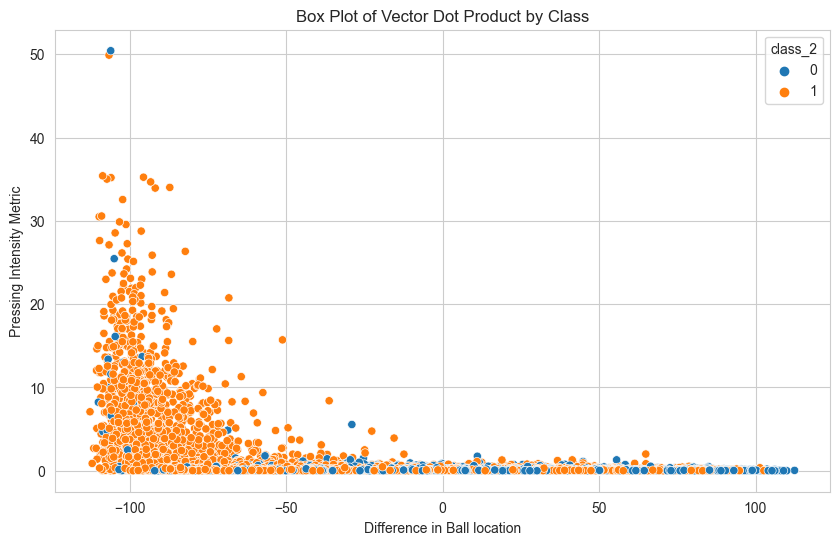

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the box plot
sns.scatterplot(x='difference_in_actor_pos', y='spec_metric', data=df,hue='class_2')

# Add labels and title
plt.xlabel('Difference in Ball location')
plt.ylabel('Pressing Intensity Metric')
plt.title('Box Plot of Vector Dot Product by Class')

# Show the plot
plt.show()

In [175]:
df.to_csv('spatiotemporal_data2.csv',index=False)

In [176]:
df.shape

(31318, 107)